<a href="https://colab.research.google.com/github/rondinellimorais/speaker_recognition/blob/main/Speaker_recognition_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speaker Recognition

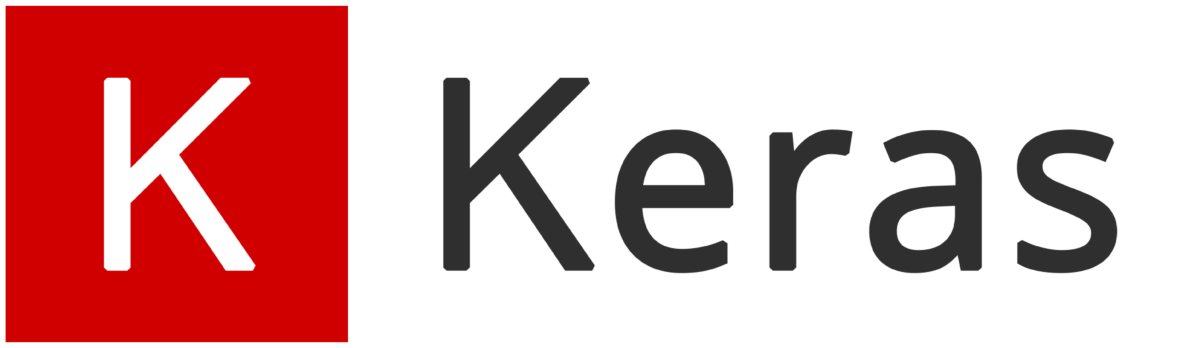

**Description:** A simple Speaker classifier using **Keras**

**Author:** Rondinelli Morais

## Setup

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 5.1 MB/s 


In [ ]:
import os
import shutil
import librosa
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
from librosa.display import waveshow
from IPython.display import Audio, display
from sklearn.metrics import confusion_matrix
from datetime import datetime, timezone, timedelta
from sklearn.model_selection import train_test_split

In [ ]:
# our dataset directory
ROOT_FOLDER = 'audio_dataset/16000_pcm_speeches'

# organization sub directory
AUDIO_FOLDER = 'audio'
NOISE_FOLDER = 'noise'
SUBFOLDER_TO_CREATE = [AUDIO_FOLDER, NOISE_FOLDER]

# Number of examples to ploting
SAMPLES_NUMBER = 10

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# Number of chunks we are going
# to split our dataset for training
BATCH_SIZE = 128

EPOCHS = 100

TEST_SIZE = 0.33

TZ_PT_BR = -3

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

In [ ]:
drive.mount('/content/drive')

!ln -s /content/drive/MyDrive/DEEP\ LEARNING/dataset dataset
!ln -s /content/drive/MyDrive/DEEP\ LEARNING/projects/voice_classifier voice_classifier

!cp dataset/speaker-recognition-dataset.zip ./
!7z x speaker-recognition-dataset.zip -oaudio_dataset

Mounted at /content/drive

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 241803761 bytes (231 MiB)

Extracting archive: speaker-recognition-dataset.zip
 54% 4096 Open              --
Path = speaker-recognition-dataset.zip
Type = zip
Physical Size = 241803761

  0%      4% 329 - 16000_pcm_speeches/Benjamin_Netanyau/1294.wav                                                          7% 612 - 16000_pcm_speeches/Benjamin_Netanyau/2.wav                                                      10% 874 - 16000_pcm_speeches/Be

## Util

In [ ]:
def path_to_audio(path):
  """Reads and decodes an audio file."""
  return librosa.load(path, sr=SAMPLING_RATE)

def reshape(arr, shape=(128, 32, 1)):
  """Reshape numpy array"""
  return arr.reshape(shape)

def audio_to_melspectrogram(path):
  """Compute a mel-scaled spectrogram."""
  y, sr = path_to_audio(path)
  sgram = librosa.stft(y)
  sgram_mag, _ = librosa.magphase(sgram)
  mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr, n_fft=1024)
  mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.max)
  return mel_sgram

## Dataset preparation

In [ ]:
for dir in SUBFOLDER_TO_CREATE:
  if not os.path.exists(ROOT_FOLDER+'/'+dir):
    os.makedirs(ROOT_FOLDER+'/'+dir)

move_config = []
for root, dirs, _ in os.walk(ROOT_FOLDER):
  for dir in dirs:
    if not dir in SUBFOLDER_TO_CREATE:
      if dir in ['other', '_background_noise_']:
        move_config.append({
          'src': os.path.join(root, dir),
          'dst': os.path.join(ROOT_FOLDER, NOISE_FOLDER)
        })
      else:
        move_config.append({
          'src': os.path.join(root, dir),
          'dst': os.path.join(ROOT_FOLDER, AUDIO_FOLDER)
        })

for config in move_config:
  shutil.move(config['src'], config['dst'])

## Visualize the data 

In [ ]:
audio_paths = glob(os.path.join(ROOT_FOLDER, AUDIO_FOLDER, '**/*.wav'))

**Wave form**

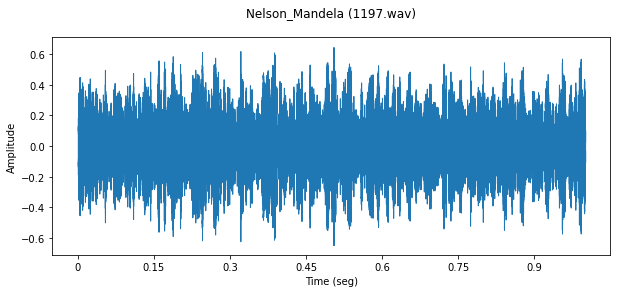

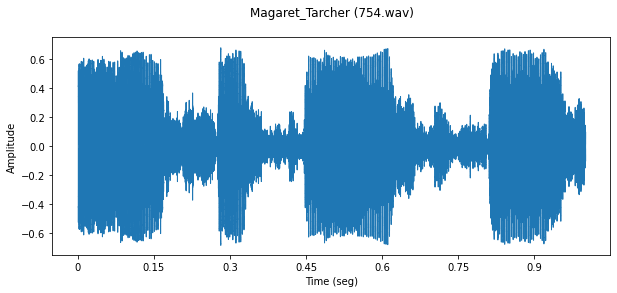

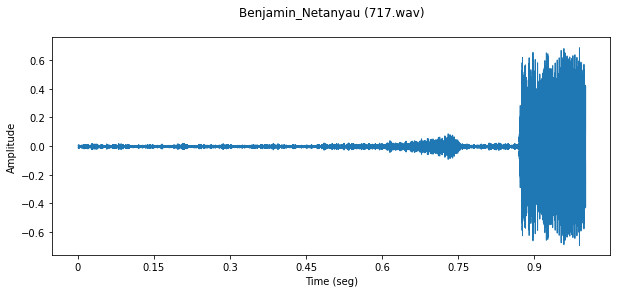

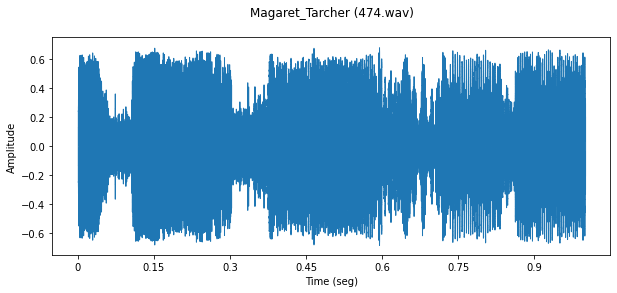

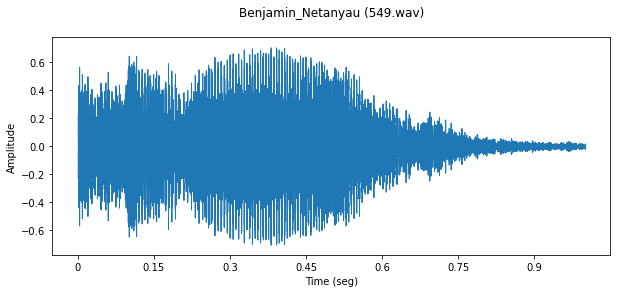

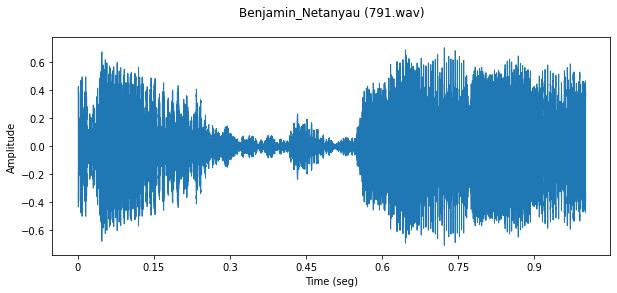

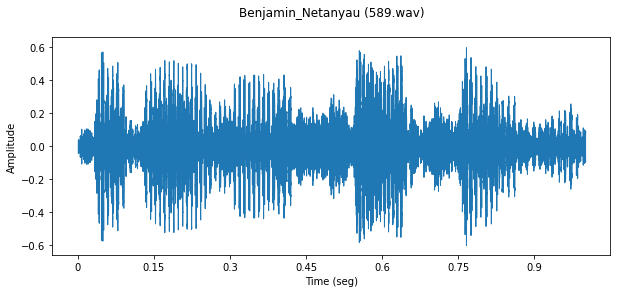

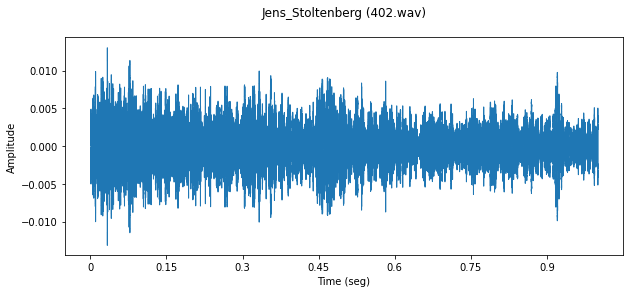

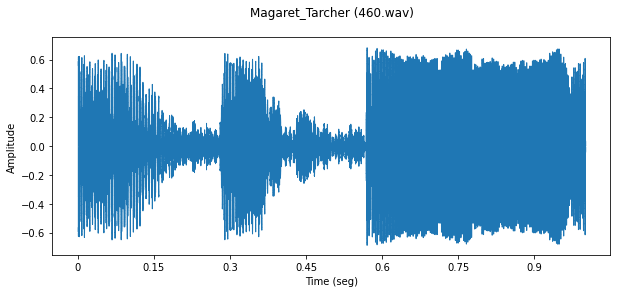

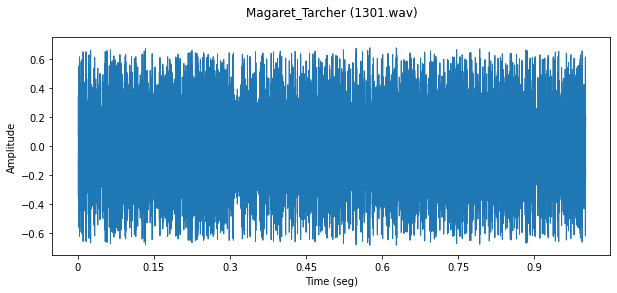

In [ ]:
samples_paths = np.random.choice(audio_paths, SAMPLES_NUMBER)
for path in samples_paths:
  sample, sampling_rate = path_to_audio(path)

  fig, ax = plt.subplots()
  fig.set_figwidth(10.)
  
  waveshow(sample, sr=sampling_rate, ax=ax)
  
  ax.set_ylabel('Amplitude')
  ax.set_xlabel('Time (seg)')
  ax.set(title=path.split('/')[-2] + ' (%s)\n' % path.split('/')[-1])
  ax.label_outer()

**Mel spectrogram**

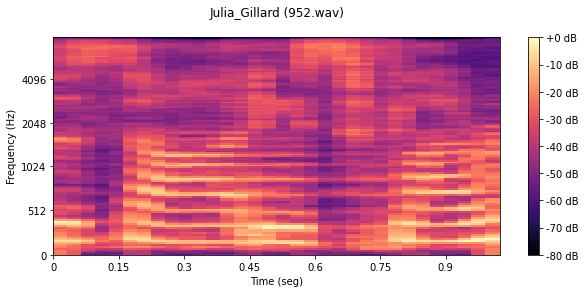

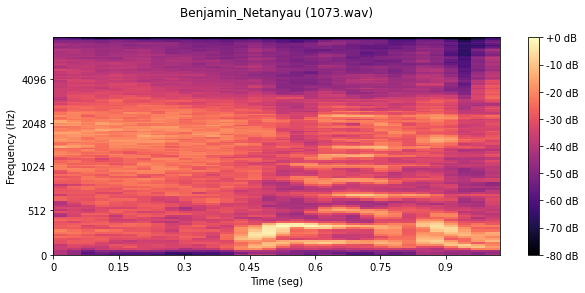

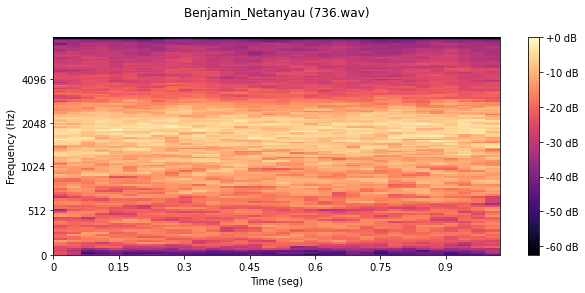

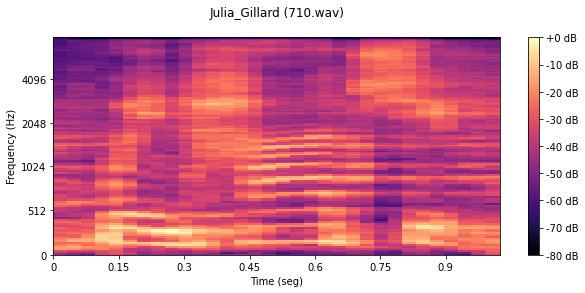

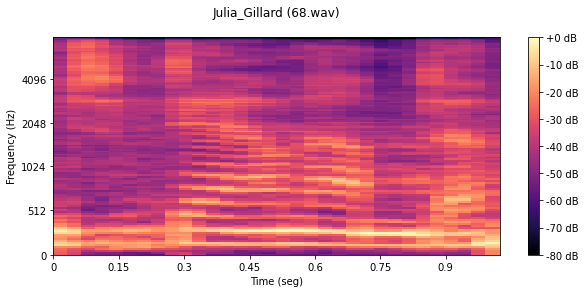

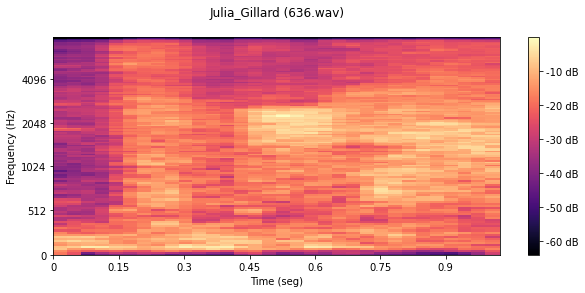

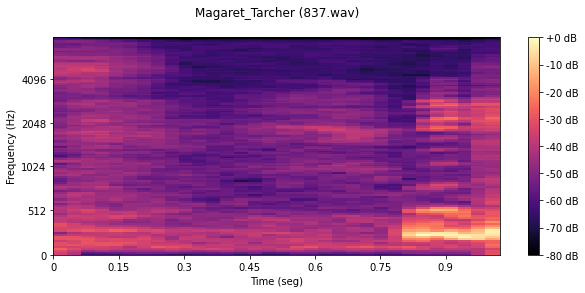

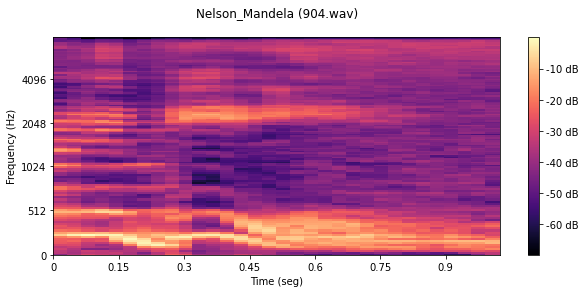

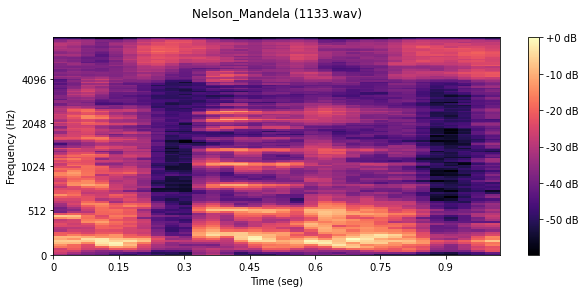

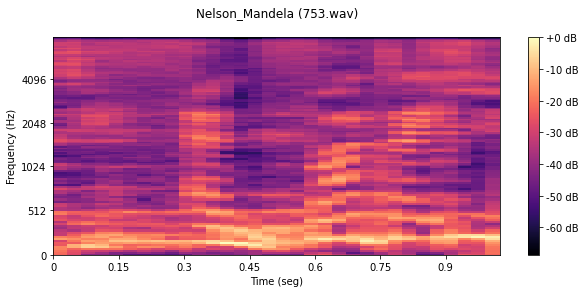

In [ ]:
samples_paths = np.random.choice(audio_paths, SAMPLES_NUMBER)
for path in samples_paths:
  fig, ax = plt.subplots()
  fig.set_figwidth(10.)

  mel_sgram = audio_to_melspectrogram(path)
  img = librosa.display.specshow(mel_sgram, sr=SAMPLING_RATE, x_axis='time', y_axis='mel', ax=ax)

  fig.colorbar(img, ax=ax, format="%+2.f dB")
  ax.set_ylabel('Frequency (Hz)')
  ax.set_xlabel('Time (seg)')
  ax.set(title=path.split('/')[-2] + ' (%s)\n' % path.split('/')[-1])
  ax.label_outer()

**Metadata**

In [ ]:
samples_paths = np.random.choice(audio_paths, SAMPLES_NUMBER)
for path in samples_paths:
  sample, sampling_rate = path_to_audio(path)

  print('Audo Info ====')
  print('Path.....: %s' % path)
  print('Shape....: {}'.format(sample.shape))
  print('Frequency: %d kHz' % sampling_rate)
  print('Duration.: %d seg' % librosa.get_duration(y=sample, sr=sampling_rate))

  print('\n')
  display(Audio(path))
  print('\n')

Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Benjamin_Netanyau/1469.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Magaret_Tarcher/1283.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Nelson_Mandela/359.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Julia_Gillard/680.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Jens_Stoltenberg/1237.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Jens_Stoltenberg/202.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Jens_Stoltenberg/820.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Jens_Stoltenberg/906.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Benjamin_Netanyau/1102.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg






Audo Info ====
Path.....: audio_dataset/16000_pcm_speeches/audio/Nelson_Mandela/215.wav
Shape....: (16000,)
Frequency: 16000 kHz
Duration.: 1 seg




## Dataset generation

In [ ]:
class_names = os.listdir(Path(ROOT_FOLDER)/AUDIO_FOLDER)
print("Our class names: {}".format(class_names,))

X = []
y = []
for label, name in enumerate(class_names):
  print("Processing speaker {}".format(name,))
  dir_path = Path(ROOT_FOLDER) / AUDIO_FOLDER / name

  speaker_sample_paths = [
      os.path.join(dir_path, filepath)
      for filepath in os.listdir(dir_path)
      if filepath.endswith(".wav")
  ]
  X += speaker_sample_paths
  y += [label] * len(speaker_sample_paths)

print(
  "Found {} files belonging to {} classes.".format(len(X), len(class_names))
)

Our class names: ['Jens_Stoltenberg', 'Julia_Gillard', 'Nelson_Mandela', 'Magaret_Tarcher', 'Benjamin_Netanyau']
Processing speaker Jens_Stoltenberg
Processing speaker Julia_Gillard
Processing speaker Nelson_Mandela
Processing speaker Magaret_Tarcher
Processing speaker Benjamin_Netanyau
Found 7501 files belonging to 5 classes.


**Split into training and validation**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SHUFFLE_SEED)

print("Using %d files for training." % len(X_train))
print("Using %d files for validation." % len(X_test))

Using 5025 files for training.
Using 2476 files for validation.


**train**

In [ ]:
X_train_transformed = np.array([reshape(audio_to_melspectrogram(path)) for path in X_train])
y_train_transformed = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))

**test**

In [ ]:
X_test_transformed = np.array([reshape(audio_to_melspectrogram(path)) for path in X_test])
y_test_transformed = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

## Build a model

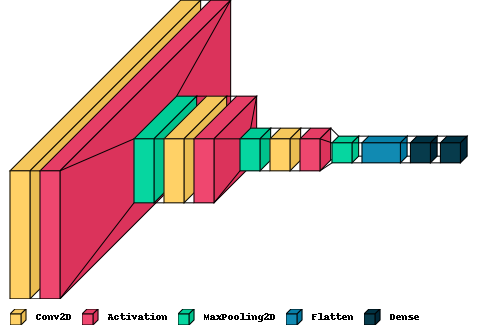

Model: "voice_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 32, 24)       624       
_________________________________________________________________
activation (Activation)      (None, 128, 32, 24)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 16, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 16, 48)        28848     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 48)     

In [ ]:
model = keras.Sequential(name='voice_classifier')

model.add(keras.Input(shape=(128, 32, 1)))

conv_config = [(1, 24), (2, 48)]
for conv_num, n_filters in conv_config:
  for _ in range(conv_num):
    model.add(layers.Conv2D(filters=n_filters, kernel_size=(5, 5), padding="same"))
    model.add(layers.Activation(tf.nn.relu))
    model.add(layers.MaxPool2D(pool_size=(4, 2), strides=(4, 2)))

# Neural Network
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(len(class_names), activation=tf.nn.softmax))

model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'],
)

display(visualkeras.layered_view(model, legend=True))
model.summary()

## Train

In [ ]:
# define our callbacks
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
  filepath='voice_classifier/backup/save_at_{epoch:02d}_{val_accuracy:.4f}.hdf5',
  monitor="val_accuracy",
  save_best_only=True
)

train_history = model.fit(
  x=X_train_transformed,
	y=y_train_transformed,
  epochs=EPOCHS,
  validation_data=(X_test_transformed, y_test_transformed),
  callbacks=[
    earlystopping_cb,
    mdlcheckpoint_cb,
  ]
)

Epoch 1/100
158/158 [==============================] - 31s 15ms/step - loss: 1.0537 - accuracy: 0.5962 - val_loss: 0.7737 - val_accuracy: 0.6991
Epoch 2/100
158/158 [==============================] - 2s 12ms/step - loss: 0.3078 - accuracy: 0.8876 - val_loss: 0.2482 - val_accuracy: 0.9124
Epoch 3/100
158/158 [==============================] - 2s 12ms/step - loss: 0.1134 - accuracy: 0.9594 - val_loss: 0.1393 - val_accuracy: 0.9507
Epoch 4/100
158/158 [==============================] - 2s 12ms/step - loss: 0.1128 - accuracy: 0.9630 - val_loss: 0.3786 - val_accuracy: 0.8922
Epoch 5/100
158/158 [==============================] - 2s 12ms/step - loss: 0.0891 - accuracy: 0.9696 - val_loss: 0.1278 - val_accuracy: 0.9519
Epoch 6/100
158/158 [==============================] - 2s 12ms/step - loss: 0.0473 - accuracy: 0.9841 - val_loss: 0.0735 - val_accuracy: 0.9758
Epoch 7/100
158/158 [==============================] - 2s 12ms/step - loss: 0.0917 - accuracy: 0.9694 - val_loss: 0.1669 - val_accuracy

## Evaluation

**Train history**

In [ ]:
now = datetime.now(tz=timezone(timedelta(hours=TZ_PT_BR)))

path = 'voice_classifier/train/{}'.format(now.strftime('%Y-%m-%d'))

if not os.path.exists(path):
  os.makedirs(path)

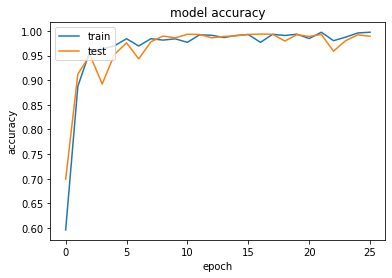

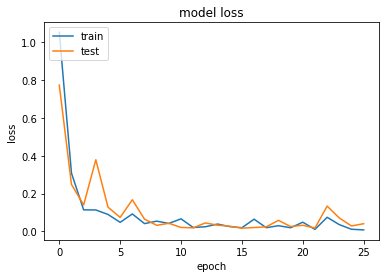

In [ ]:
# summarize history for accuracy
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('%s/model_accuracy_%s.jpeg' % (path, now.strftime('%Hh%M')))
plt.show()

# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('%s/model_loss_%s.jpeg' % (path, now.strftime('%Hh%M')))
plt.show()

**Confusion Matrix**

In [ ]:
pd.DataFrame(class_names, columns=['Speaker'])

,Speaker
0,Jens_Stoltenberg
1,Julia_Gillard
2,Nelson_Mandela
3,Magaret_Tarcher
4,Benjamin_Netanyau


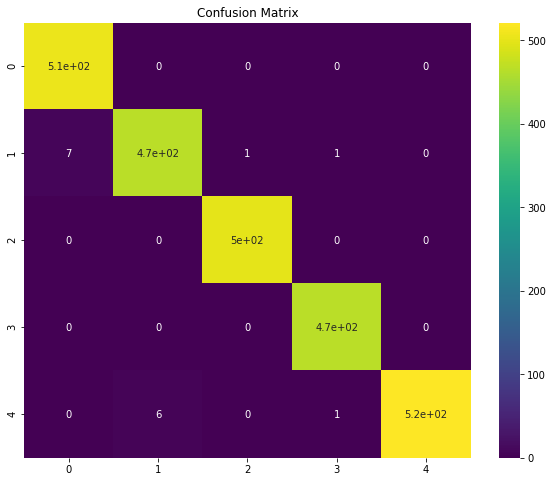

In [ ]:
predictions = model.predict(X_test_transformed)

indexes = [i for i,v in enumerate(class_names)]
y_true = [class_names[idx] for idx in y_test]
y_pred = [class_names[idx] for idx in np.argmax(predictions, axis=1)]

conf_mat = confusion_matrix(y_true, y_pred, labels=class_names)
df_cm = pd.DataFrame(conf_mat, index=indexes, columns=indexes)
plt.figure(figsize=(10, 8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()

**Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

 Jens_Stoltenberg       1.00      0.99      0.99       528
    Julia_Gillard       0.99      1.00      0.99       506
   Nelson_Mandela       0.99      0.98      0.98       476
  Magaret_Tarcher       1.00      1.00      1.00       467
Benjamin_Netanyau       1.00      1.00      1.00       499

         accuracy                           0.99      2476
        macro avg       0.99      0.99      0.99      2476
     weighted avg       0.99      0.99      0.99      2476



## Demonstration

In [ ]:
SAMPLES_TO_DISPLAY = 5

for _ in range(SAMPLES_TO_DISPLAY):
  idx = np.random.randint(len(X_test))
  
  path = X_test[idx]
  mel_spec = reshape(audio_to_melspectrogram(path))
  predictions = model.predict(mel_spec[np.newaxis, :])
  y_pred = np.argmax(predictions)

  # For every sample, print the true and predicted label
  # as well as run the voice with the noise
  print(
    "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
      "[92m" if class_names[y_test[idx]] == class_names[y_pred] else "[91m",
      class_names[y_test[idx]],
      "[92m" if class_names[y_test[idx]] == class_names[y_pred] else "[91m",
      class_names[y_pred],
    )
  )
  display(Audio(path_to_audio(path)[0], rate=SAMPLING_RATE))
  print()

Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg



Speaker: Benjamin_Netanyau	Predicted: Julia_Gillard



Speaker: Julia_Gillard	Predicted: Julia_Gillard



Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg



Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


## References

- https://keras.io/examples/audio/speaker_recognition_using_cnn/
- https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
- https://www.tensorflow.org/io/tutorials/audio
- https://www.tensorflow.org/tutorials/audio/simple_audio
- https://librosa.org/doc/latest/core.html
- `augmentation` https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52
- https://github.com/markadivalerio/audio-classifier-project
- https://github.com/ajhalthor/audio-classifier-convNet/blob/master/env_sound_discrimination.ipynb